In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [ ]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

# Computational Domain

nx=Nx//nproc; ny=Ny; nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:1] 
n_proc = 8
rank = 0


In [4]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "enstrophy-szalay-"+str(rank)+".npz"

file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    #if(int(content['nproc'])!=nproc):
    #    print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] 
Finished loading
Load from disk: 4.34 seconds


In [5]:
%%px

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype='float32')

comm.Reduce([avgOmega,MPI.REAL],[avgOmegaGl,MPI.REAL],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)

##########################

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype='float32')
maxwGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minw2,MPI.REAL],[minwGl,MPI.REAL])
comm.Allgather([maxw2,MPI.REAL],[maxwGl,MPI.REAL])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("0.5 <w^2> : "+str(avgOmega/2))
    print("<w^2> : "+str(avgOmega))
    print("min w2 : "+str(minw2))
    print("max w2 : "+str(maxw2))
    print("min w2/<w^2> : "+str(minw2/avgOmega))
    print("min w2/<w^2> : "+str(maxw2/avgOmega))

[stdout:1] 
0.5 <w^2> : 245.580307007
<w^2> : 491.160614014
min w2 : 9.39717e-06
max w2 : 258231.0
min w2/<w^2> : 1.91325866702e-08
min w2/<w^2> : 525.757337839


In [6]:
%%px

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

comm.Barrier(); t1=MPI.Wtime()

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')
cchi = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
corr = ft.zeros_aligned((nx,ny,nz),dtype='float32')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Alocating vectors: 24.32 seconds


In [7]:
%%px

t = 5

chi[:,:,:] = 0
chi[w2 > t*avgOmega] = 1

N = np.sum(chi)
NGl=np.zeros(1,dtype='float32')

comm.Allreduce([N,MPI.REAL],[NGl,MPI.REAL],op=MPI.SUM)

if rank==0:
    print(int(NGl[0]))

[stdout:1] 37259068


In [8]:
%%px

t = 5
c = 'r'

chi[:,:,:] = 0
chi[w2 > t*avgOmega] = 1

In [9]:
%%px

cchi[:,:,:] = fft.forward3Dfft(chi,nx,ny,nz,nproc,rank)

In [10]:
%%px

tmp = cchi*(cchi.conj())

In [11]:
%%px

minAbs = np.min(np.sqrt(tmp.real))
maxAbs = np.max(np.sqrt(tmp.real))

minGl=np.zeros(nproc,dtype='float32')
maxGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minAbs,MPI.REAL],[minGl,MPI.REAL])
comm.Allgather([maxAbs,MPI.REAL],[maxGl,MPI.REAL])

ming = minGl.min()
maxg = maxGl.max()

if rank==0:
    print("Global min: "+str(ming))
    print("Global max: "+str(maxg))
    print("Global ratio: "+str(maxg/ming) )

[stdout:1] 
Global min: 2.47349e-10
Global max: 0.0347002
Global ratio: 1.40288e+08


In [12]:
%%px

if rank==0:
    print(tmp[0,0,0])
    tmp[0,0,0] = np.complex64(0+0.0j)
    print(tmp[0,0,0])

[stdout:1] 
(0.0012041+0j)
0j


In [13]:
%%px

corr[:,:,:] = fft.backward3Dfft(tmp,nx,ny,nz,nproc,rank)

In [14]:
%%px

fct = 1024**3/37259068

corr[0,0,0] *= fct

In [15]:
%%px

if rank==0:
    print(corr[0,0,0])

[stdout:1] 0.9653


In [16]:
%%px

iCorr = ft.zeros_aligned((nx,ny//2,nz//2),dtype='float32')

X  = np.zeros((nx,ny//2,nz//2), dtype='float32')
Y  = np.zeros((nx,ny//2,nz//2), dtype='float32')
Z  = np.zeros((nx,ny//2,nz//2), dtype='float32')

r2 = np.zeros((nx,ny//2,nz//2), dtype='float32')

In [17]:
%%px

islog = False

In [45]:
%%px

comm.Barrier(); t1=MPI.Wtime()

if rank<4:
    for i in range(nx):
        X[i,:,:] = (i+rank*nx+0.5)*isotropic1024coarse['dx']
        
    for j in range(ny//2):
        Y[:,j,:] = (j+0.5)*isotropic1024coarse['dy']
        
    for k in range(nz//2):
        Z[:,:,k] = (k+0.5)*isotropic1024coarse['dz']
        
    r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

else:
    r2[:,:,:] = 0.

r2rt = np.sqrt(r2)
if(islog==True):
    if rank<4:
        r2rt = np.log(r2rt)
    else:
        r2rt[:,:,:] = -100.
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing the real domain for radial integration: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Preparing the real domain for radial integration: 3.29 seconds


    % compute the bin size
    rmax = max(max(max(rr)));
    rmin = min(min(min(rr)));

In [54]:
%%px

minr2rt = r2rt.min()
maxr2rt = r2rt.max()

In [55]:
%%px

if rank>=4:
    minr2rt =  10**3
    maxr2rt = -10**3    

In [57]:
%%px

minr2rtGl=np.zeros(nproc,dtype='float32')
maxr2rtGl=np.zeros(nproc,dtype='float32')

In [58]:
%%px

minrt = np.zeros(1,dtype='float32')
maxrt = np.zeros(1,dtype='float32')

minrt[0] = minr2rt
maxrt[0] = maxr2rt

In [60]:
%%px

comm.Allgather([minrt,MPI.REAL],[minr2rtGl,MPI.REAL])
comm.Allgather([maxrt,MPI.REAL],[maxr2rtGl,MPI.REAL])

In [69]:
%%px

mingrt = minr2rtGl.min()
maxgrt = maxr2rtGl.max()


    sc   = (rmax-rmin)/(nbins-1);
    bins = 1 + int16(floor((rr-rmin)/sc));
    s1   = rmin + (single(bins)-1)*sc;
    s    = unique(s1(:));
end    

In [71]:
%%px

nbins = 16

In [72]:
%%px

sc = (maxgrt-mingrt)/(nbins-1)

In [73]:
%%px

bins = np.zeros(nbins,dtype='float32')

In [74]:
%%px

for i in range(nbins):
    bins[i] = mingrt + i*sc

In [58]:
%%px 

if rank<4:
    iCorr[0:nx,0:(ny//2),0:(nz//2)] = corr[0:nx,0:(ny//2),0:(nz//2)]
else:
    iCorr[:,:,:] = 0.

In [59]:
%%px

if rank==0:
    print(logrbins/dx)

[stdout:6] 
[  7.07106781e-01   1.01017909e+00   1.44315090e+00   2.06169831e+00
   2.94536068e+00   4.20776867e+00   6.01125604e+00   8.58773427e+00
   1.22685142e+01   1.75269093e+01   2.50390997e+01   3.57710823e+01
   5.11028888e+01   7.30060450e+01   1.04297090e+02   1.48999758e+02
   2.12862390e+02   3.04097118e+02   4.34435869e+02   6.20638977e+02
   8.86650406e+02]


In [60]:
%%px

if rank<4:
    corrLoc,redges = np.histogram(r2rt,range=(minr2rt,maxr2rt),bins = logrbins,weights=iCorr)
    
    r2Loc,r2edges = np.histogram(r2rt,range=(minr2rt,maxr2rt),bins = logrbins)

In [61]:
%%px

if rank==0:
    print(corrLoc.shape)
    print(corrLoc.dtype)
    print(redges.shape)
    print(redges.dtype)

[stdout:6] 
(20,)
float32
(21,)
float64


In [62]:
%%px

if rank>=4:
    corrLoc = np.zeros(20,dtype='float32')
    redges = np.zeros(20,dtype='float32')
    
    r2Loc = np.zeros(20,dtype='float32')
    r2edges = np.zeros(20,dtype='float32')

In [63]:
%%px

corrSum = np.zeros(corrLoc.shape[0],dtype='float32')
r2Sum = np.zeros(corrLoc.shape[0],dtype='float32')

corrF = np.zeros(corrLoc.shape[0],dtype='float32')
r2F = np.zeros(corrLoc.shape[0],dtype='float32')

In [64]:
%%px

if rank==0:
    print(corrF.shape)
    print(corrSum.shape)

[stdout:6] 
(20,)
(20,)


In [65]:
%%px

corrLoc=np.float32(corrLoc)
comm.Allreduce([corrLoc,MPI.REAL],[corrSum,MPI.REAL],op=MPI.SUM)

In [51]:
%%px

if rank==0:
    print(corrSum.shape)
    print(logrbins.shape)
    print(logrbins)

[stdout:6] 
(20,)
(21,)
[  4.33875287e-03   6.19838124e-03   8.85506300e-03   1.26504224e-02
   1.80725068e-02   2.58185452e-02   3.68846051e-02   5.26936775e-02
   7.52786600e-02   1.07543768e-01   1.53637992e-01   2.19488612e-01
   3.13563399e-01   4.47959482e-01   6.39958931e-01   9.14251066e-01
   1.30610727e+00   1.86591655e+00   2.66566511e+00   3.80819307e+00
   5.44041875e+00]


In [75]:
%%px

if rank == 0:
    size = logrbins.shape[0]
    bincenter = np.sqrt(logrbins[0:size-1]*logrbins[1:size])
    binratio  = logrbins[1:size]/logrbins[0:size-1]
    print(bincenter.shape)

[stdout:6] (20,)


[output:6]

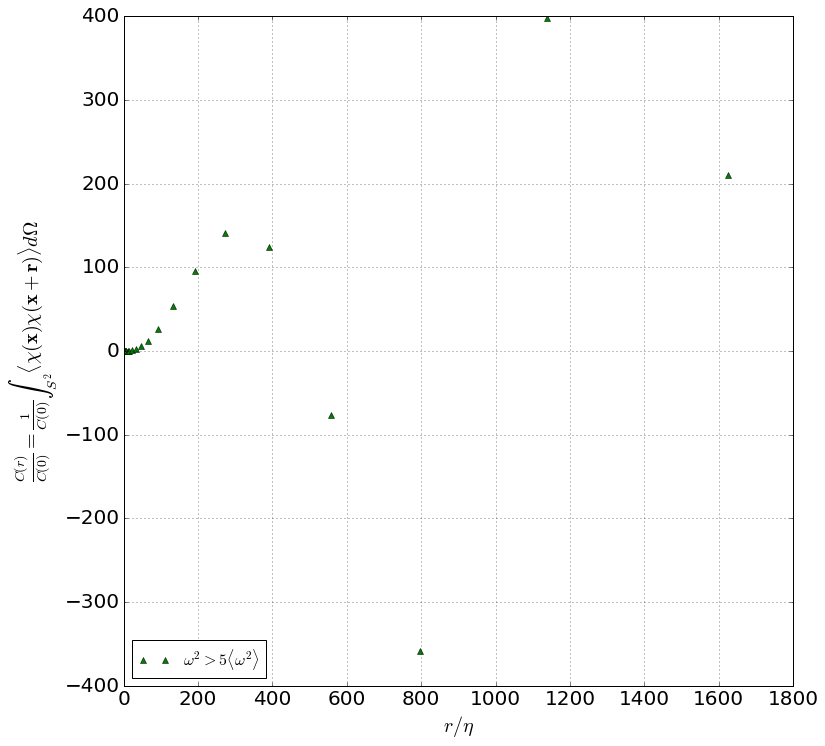

In [76]:
%%px
%matplotlib inline

eta = 0.00280

if(rank==0):
    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    
    rp = bincenter
    
    plt.figure(figsize=(12,12))
    plt.xlabel(r'$r/\eta$', fontsize=20)
    plt.ylabel(r'$\frac{C(r)}{C(0)} = \frac{1}{C(0)} \int_{S^2} \langle \chi({\bf x}) \chi({\bf x}+{\bf r}) \rangle d\Omega$', fontsize=20)
    #plt.xlim([7*10**(-3)/eta,np.pi/eta])
        
    plt.plot(rp/eta,(corrSum/binratio),'g^',label=r'$\omega^2 > '+str(5)
                                               +r'\langle \omega^2\rangle$')
        
    plt.grid()
        
    plt.legend(loc='lower left',prop={'size':16})